In [1]:
import os
import pandas as pd
import numpy as np
import earthpy as et
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import seaborn as sns
# Additional library needed for text processing, 
# see environment.yml for details
import spacy
from spacy import displacy

# Import the custom function
from preprocess_text import preprocess_text

# The pip install en_core_web_sm command is used to install en_core_web_sm model 
# in SpaCy. This model is a small, fast, and efficient model that is suitable 
# for exploratory NLP tasks.

In [2]:
fire_dir = os.path.join(et.io.HOME, 'earth-analytics', 'EA_fire_project')
data_dir = os.path.join(fire_dir, 'data')
tmp_dir = os.path.join(data_dir, 'processed')

In [3]:
# Open the 'dixie-caldor-threat.csv' file that was processed from 
# SIT209_HISTORY_INCIDENT_209_REPORTS_2014to2023_cleaned.csv in 
# ICS-209-PLUS-WILDFIRE_data_processing.ipynb and available from data/processed
# folder. This file contains the Dixie and Caldor fire incident reports.

try:
    focusfires_df = pd.read_csv(
        os.path.join(tmp_dir, 'dixie-caldor-threat.csv'), 
                     parse_dates=True,
                     low_memory=False)
except FileNotFoundError:
    print("Error: The 'dixie-caldor-threat.csv' was not found."
          "Please check the file path and try again.")
except pd.errors.EmptyDataError:
    print("Error: The file 'dixie-caldor-threat.csv' is empty."
          "Please provide a valid data file.")
except Exception as e:
    print(f"An unexpected error occurred while loading data: {e}")

In [4]:
df_norepeat = focusfires_df.copy()

collist = ['CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72']

for col in collist:
    # create a new column that shifts the current column down by one row
    df_norepeat['shifted'] = df_norepeat[col].shift(1)
    
    # Compare the current column with 'shifted'.
    new_col_name = f'unrepeated_{col}'
    df_norepeat[new_col_name] = (
        df_norepeat.apply(
            lambda row: 'same' if row[col] == row['shifted'] else row[col],
            axis=1)
    )
    
    # Drop the temporary 'shifted' column after use
    df_norepeat.drop(columns=['shifted'], inplace=True)

# Convert 'REPORT_TO_DATE' to datetime format
df_norepeat['REPORT_TO_DATE'] = pd.to_datetime(df_norepeat['REPORT_TO_DATE'])

# Ensure the data is numeric
df_norepeat['last_reported'] = (
	df_norepeat.groupby(
		'INCIDENT_ID')['REPORT_TO_DATE']
		.diff().dt.total_seconds() / 3600
)

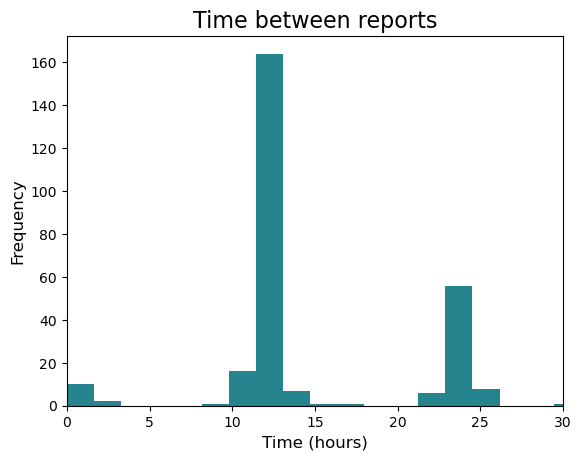

In [5]:
# Choose a color from the Viridis colormap and use the same colorscheme 
# throughout the workbook
viridis_color = cm.viridis(0.45)  

# Plot the histogram
ax = df_norepeat['last_reported'].plot(
	kind='hist', 
	# bins=len(df_norepeat),
	bins=24, 
	title='Time between reports (hours)',
	color=viridis_color
)

# Set the x-axis limit
plt.xlim(0, 30)

# Customize the font size
ax.set_title('Time between reports', fontsize=16)
ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Save the plot
plt.savefig(
    'graphics/graph_outputs/reporting_time_hist.png', format='png', dpi=300
)  
# Save as PNG with 300 dpi

# Show the plot
plt.show()

In [6]:
df_norepeat.to_csv(os.path.join(tmp_dir,'dixie-caldor-no_repeat.csv'),index=False)

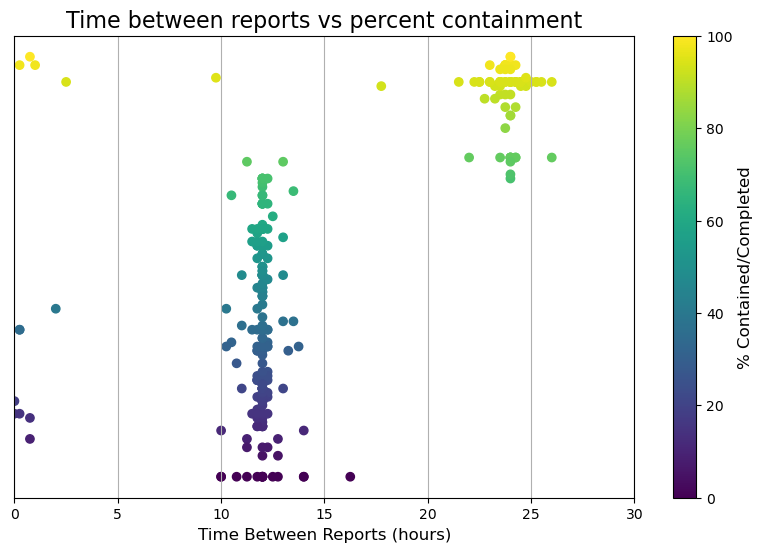

In [7]:
# Ensure the data is numeric
df_norepeat['last_reported'] = pd.to_numeric(
    df_norepeat['last_reported'], errors='coerce')
df_norepeat['PCT_CONTAINED_COMPLETED'] = pd.to_numeric(
    df_norepeat['PCT_CONTAINED_COMPLETED'], errors='coerce')

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatter = plt.scatter(df_norepeat['last_reported'],
					  df_norepeat['PCT_CONTAINED_COMPLETED'], 
					  c=df_norepeat['PCT_CONTAINED_COMPLETED'], cmap='viridis')

# Add a color bar
cbar = plt.colorbar(scatter, label='% Contained/Completed')
cbar.ax.tick_params(labelsize=10)  # Adjust color bar tick labels size
cbar.set_label('% Contained/Completed', fontsize=12)  # Adjust color bar label size

# Set the range of the x-axis
plt.xlim([0, 30])

# Customize the plot
plt.xlabel('Time Between Reports (hours)', fontsize=12)
plt.ylabel('Containment/Completion Percentage', fontsize=16)
plt.title('Time between reports vs percent containment', fontsize=16)
plt.grid(True)  # Optional: Adds a grid for easier visualization

# Hide the y-axis
plt.gca().axes.get_yaxis().set_visible(False)

# Save the plot
plt.savefig(
    'graphics/graph_outputs/scatter_timing_containment.png', format='png', dpi=300)  # Save as PNG with 300 dpi
# Show the plot
plt.show()

In [8]:
# Calculate the percentage of repeated/unrepeated values
(df_norepeat['unrepeated_CURRENT_THREAT_12'] == 'same').sum() / len(df_norepeat)
(df_norepeat['unrepeated_CURRENT_THREAT_12'] != 'same').sum() / len(df_norepeat)

0.45652173913043476

In [9]:
# Start text processing, text analysis explorations
# Load your data
data = focusfires_df

# Apply preprocessing
data['CURRENT_THREAT_12'] = (
    data['CURRENT_THREAT_12'].fillna('').apply(preprocess_text)
)

# Split data by INCIDENT_ID
incident_ids = data['INCIDENT_ID'].unique()
data_by_incident = {
    incident_id: data[data['INCIDENT_ID'] == incident_id]['CURRENT_THREAT_12']
    .tolist() for incident_id in incident_ids}

# Load the SpaCy model, check if en_core_web_sm is installed
try:
        # Attempt to load the SpaCy model
        nlp = spacy.load('en_core_web_sm')
        # Check if the model has been loaded by verifying a known component
        if 'tagger' in nlp.pipe_names:
            print("Test Passed: SpaCy model 'en_core_web_sm' loaded "
                  "successfully.")
        else:
            print("Test Failed: 'tagger' component not found in the "
                  "loaded model.")
except OSError:
        print("Test Failed: SpaCy model 'en_core_web_sm' is not installed. "
              "Please install it using "
              "'!python -m spacy download en_core_web_sm'.")
except Exception as e:
        print(f"Test Failed: An unexpected error occurred: {e}")

# Perform Named Entity Recognition (NER) and collect results in a DataFrame
ner_results = []

for incident_id, texts in data_by_incident.items():
    for text in texts:
        doc = nlp(text)
        for ent in doc.ents:
            ner_results.append({
                'INCIDENT_ID': incident_id, 
                'Entity': ent.text, 
                'Label': ent.label_})

ner_df = pd.DataFrame(ner_results)

# Save the results to a CSV file
ner_df.to_csv(os.path.join(tmp_dir,'ner_results.csv'), index=False)

Test Passed: SpaCy model 'en_core_web_sm' loaded successfully.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   INCIDENT_ID  5329 non-null   object
 1   Entity       5329 non-null   object
 2   Label        5329 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB
None
            INCIDENT_ID           Entity   Label
0  2021_12908560_CALDOR       california     GPE
1  2021_12908560_CALDOR  native american  PERSON
2  2021_12908560_CALDOR       california     GPE
3  2021_12908560_CALDOR  native american  PERSON
4  2021_12908560_CALDOR       california     GPE
Number of entities per INCIDENT_ID:
INCIDENT_ID
2021_12908560_CALDOR    1136
2021_12993824_DIXIE     4193
dtype: int64

Most common entities:
Entity
sacramento             406
california             264
day                    162
reese                  162
el dorado              155
three                  145
northern california    137
san franci

C:\Users\lucap\AppData\Local\Temp\ipykernel_43284\811778446.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


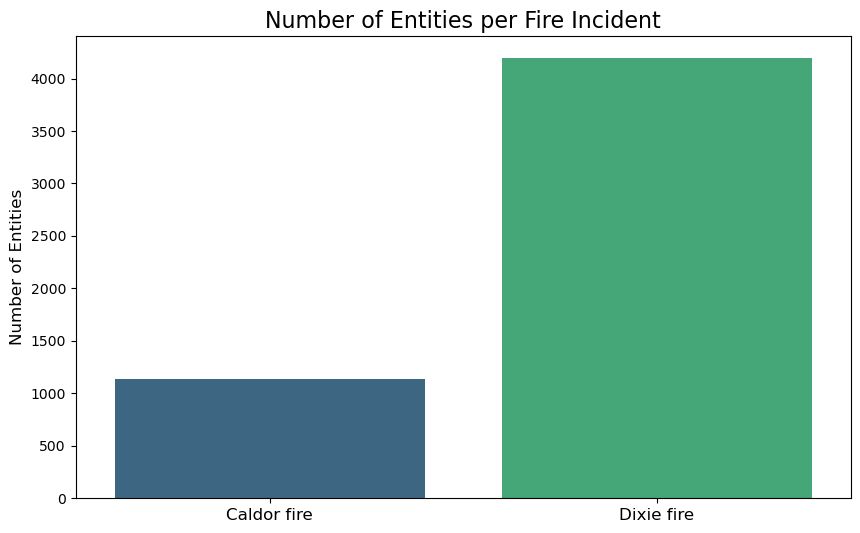

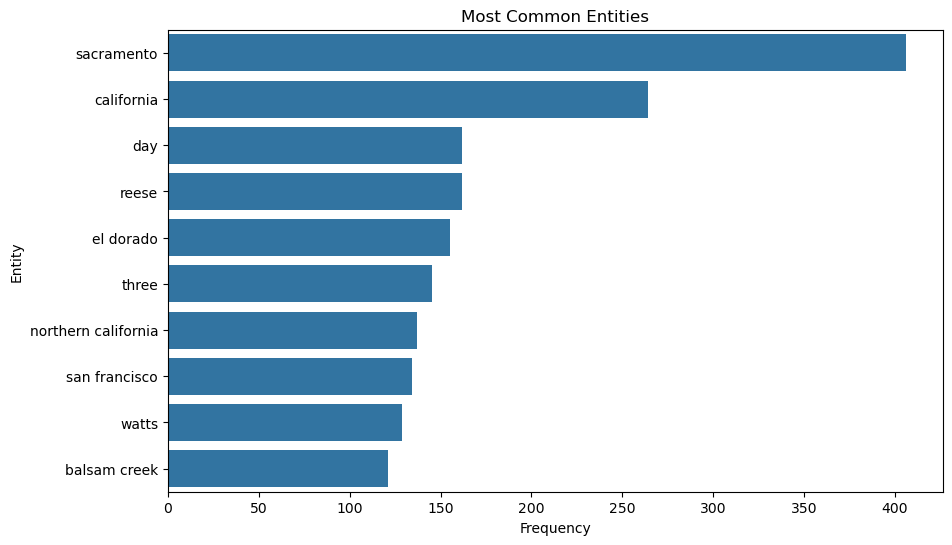

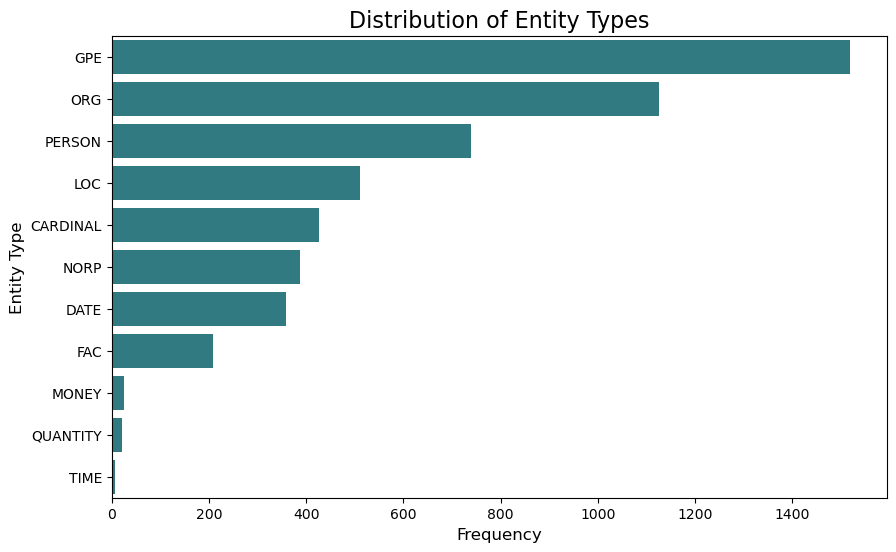

In [10]:
# Display basic information about the data
print(ner_df.info())
print(ner_df.head())

# Summary Statistics

# Number of entities per INCIDENT_ID
entities_per_incident = ner_df.groupby('INCIDENT_ID').size()
print("Number of entities per INCIDENT_ID:")
print(entities_per_incident)

# Most common entities
most_common_entities = ner_df['Entity'].value_counts().head(10)
print("\nMost common entities:")
print(most_common_entities)

# Distribution of entity types
entity_type_distribution = ner_df['Label'].value_counts()
print("\nDistribution of entity types:")
print(entity_type_distribution)

# Visualization

# Number of entities per INCIDENT_ID
entities_per_incident = ner_df.groupby('INCIDENT_ID').size()

# Mapping dictionary for INCIDENT_ID to fire names
incident_id_to_fire_name = {
	'2021_12908560_CALDOR': 'Caldor fire',
	'2021_12993824_DIXIE': 'Dixie fire'
}

# Apply the mapping to the index
entities_per_incident.index = (
    entities_per_incident.index.map(incident_id_to_fire_name)
)

# Visualization
# Select a specific color from the viridis colormap to use across graphs
viridis_color = cm.viridis(0.45)

# Bar plot of number of entities per INCIDENT_ID
plt.figure(figsize=(10, 6))
sns.barplot(
    x=entities_per_incident.index, 
    y=entities_per_incident.values, 
    palette='viridis')
plt.title('Number of Entities per Fire Incident', fontsize=16)
# Turn off the x-axis title and set font size
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Entities', fontsize=12)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=10)  
# plt.xticks(rotation=90)

# Save the plot as a PNG file
plt.savefig('graphics/graph_outputs/entities_per_fire.png')

plt.show()

# Bar plot of the most common entities
plt.figure(figsize=(10, 6))
sns.barplot(
    x=most_common_entities.values, 
    y=most_common_entities.index)
plt.title('Most Common Entities')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

# Bar plot of the distribution of entity types
plt.figure(figsize=(10, 6))
sns.barplot(
    x=entity_type_distribution.values, 
    y=entity_type_distribution.index, 
    color=viridis_color)
plt.title('Distribution of Entity Types', fontsize=16) 
plt.xlabel('Frequency', fontsize=12)  
plt.ylabel('Entity Type', fontsize=12) 
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 


# Save the plot as a PNG file
plt.savefig('graphics/graph_outputs/entity_type_distribution.png')

plt.show()

In [11]:
# Filter the NER results for GPE (Geo-Political Entities) entities
gpe_entities = ner_df[ner_df['Label'] == 'GPE']

C:\Users\lucap\AppData\Local\Temp\ipykernel_43284\3069785587.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


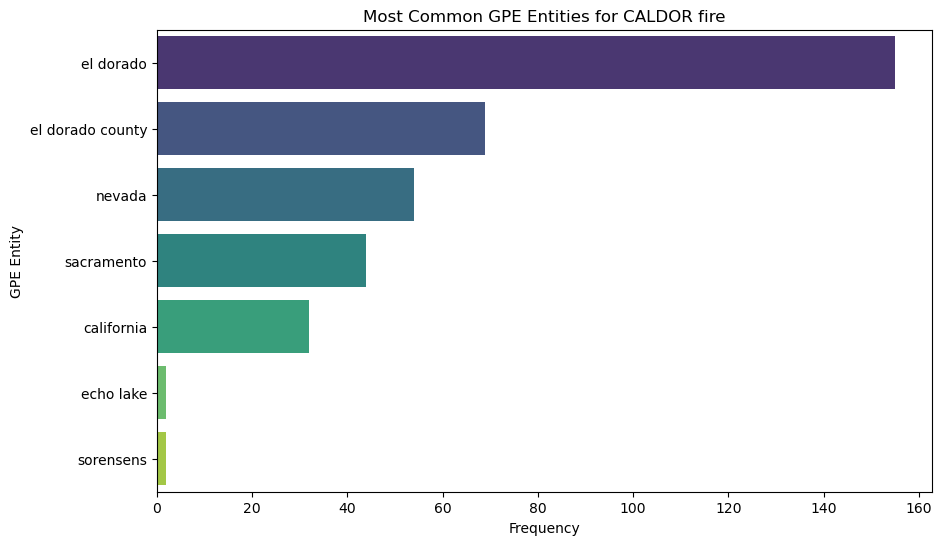

C:\Users\lucap\AppData\Local\Temp\ipykernel_43284\3069785587.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


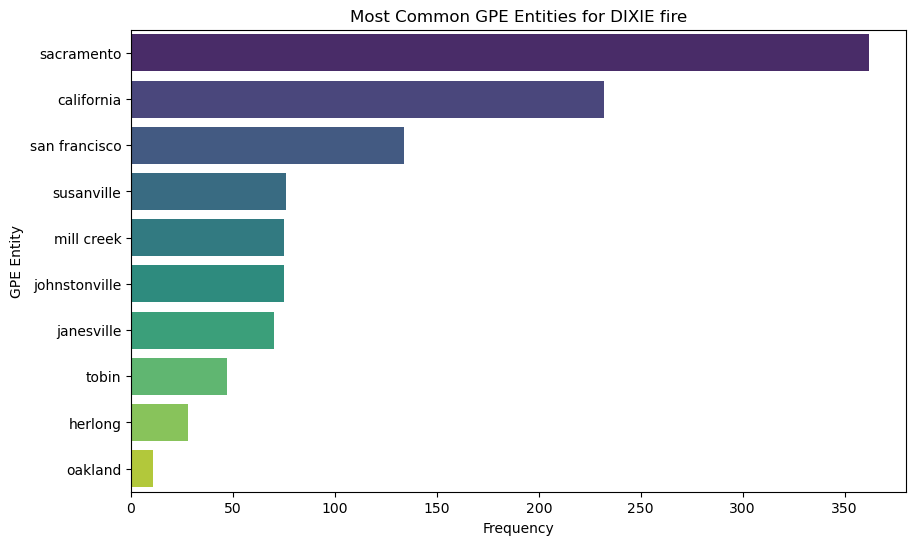

In [12]:
# Filter GPE entities once outside the loop for efficiency
incident_gpe_entities = {
    incident_id: gpe_entities[gpe_entities['INCIDENT_ID'] == incident_id] 
                         for incident_id in incident_ids}

# Create a plot for each INCIDENT_ID
for incident_id, gpe_data in incident_gpe_entities.items():
    # Count the occurrences of each GPE entity
    gpe_counts = gpe_data['Entity'].value_counts().head(10)
    
    # Extract the title from the INCIDENT_ID
    title = incident_id.split('_')[-1]
    
    # Plot the most common GPE entities
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x=gpe_counts.values, 
        y=gpe_counts.index, 
        palette='viridis', 
        ax=ax)
    ax.set_title(f'Most Common GPE Entities for {title} fire')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('GPE Entity')
    plt.show()


In [13]:
# Initialize SpaCy with the small, English language model 'en_core_web_sm'
nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a test for Dixie fire.")
displacy.render(doc, style="dep")

In [14]:
# Start testing some input text to check the recognized entities
# Load the test text inputs
try:
    test_text = pd.read_csv(os.path.join(tmp_dir, 'test_text_inputs.csv'))
except FileNotFoundError:
    print("Error: The file 'test_text_inputs.csv' was not found. "
          "Please check the file path and try again.")
except pd.errors.EmptyDataError:
    print("Error: The file 'test_text_inputs.csv' is empty. Please provide a "
          "valid data file.")
except Exception as e:
    print(f"An unexpected error occurred while loading data: {e}")

# Access the first row of the DataFrame
try:
    text = test_text.iloc[0, 0]
except TypeError:
    print("Error: The input text is not valid. Please check type format "
          "(string).")
except Exception as e:
    print(f"An unexpected error occurred during text input: {e}")

# Process the text with the NLP model
doc = nlp(text)

# Extract sentence spans
sentence_spans = list(doc.sents)

# Render the entities in the text
displacy.render(sentence_spans, style="ent")

c:\Users\lucap\miniconda3\envs\earth-analytics-python\lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [15]:
# Access the next row of the test_text_inputs
text = test_text.iloc[1, 0]
doc = nlp(text)
sentence_spans = list(doc.sents)
displacy.render(sentence_spans, style="ent")

In [16]:
# Access the next row of the test_text_inputs, the most complex, longest test
text = test_text.iloc[2, 0]
doc = nlp(text)
sentence_spans = list(doc.sents)
displacy.render(sentence_spans, style="ent")